# Advanced ML - EX1

## Load the data

### Imports

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')



/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Split the data into training and testing sets
# x_train, x_test = mnist.data[:60000], mnist.data[60000:]
# y_train, y_test = mnist.target[:60000], mnist.target[60000:]

x_train, x_test = mnist.data[:600], mnist.data[600:]
y_train, y_test = mnist.target[:600], mnist.target[600:]

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (600, 784)
Training labels shape: (600,)
Test data shape: (69400, 784)
Test labels shape: (69400,)



### Data exploration

Describe the data

In [4]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 3.6 MB


In [5]:
null_vals = x_train.isna().sum()
print(f"There are {len(null_vals[null_vals != 0])} missing values in x_train.")

There are 0 missing values in x_train.


Present the label distribution

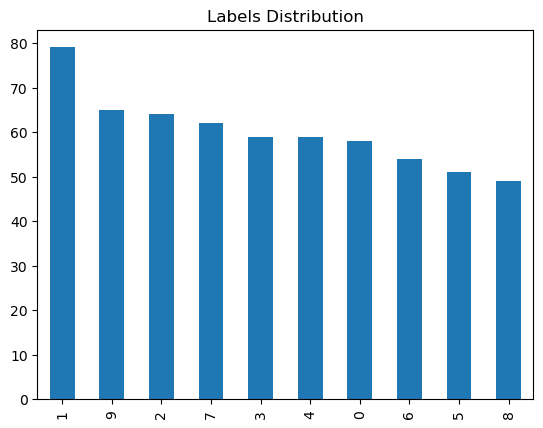

In [6]:
y_train.value_counts(dropna=False).plot(kind='bar')
plt.title("Labels Distribution") 
plt.show()

Present some of the images:

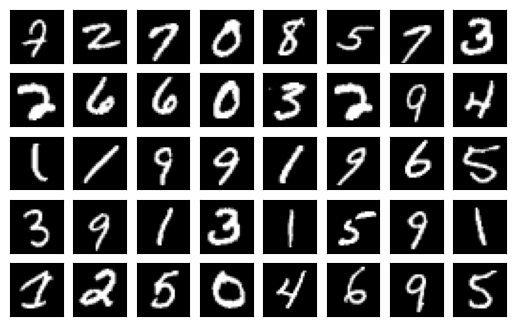

In [7]:
N=40
images= np.random.randint(low=0, high=600, size=N).tolist()

images = x_train.iloc[images,:]
# images.drop(columns=['label'], inplace=True)
images.index = range(1, N+1)

for i, row in images.iterrows():
    plt.subplot(N//8 + 1, 8, i)
    pixels = row.values.reshape((28,28))
    plt.imshow(pixels, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


## Part 1 - Clustering

### Imports

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score


### Cluster

In [72]:
def cluster_data(data, clustering_algorithm, hyperparams):
    """
    Cluster the input data using the specified clustering algorithm and hyperparameters.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm
    Returns:
    numpy array: cluster labels for each data point
    """    
    clustering_model = clustering_algorithm(**hyperparams)
    cluster_per_data_point = clustering_model.fit_predict(data)
    return clustering_model, cluster_per_data_point

### Visualize

In [73]:
def visualize_clusters(data, labels, n_clusters):
    """
    Visualize the clusters by displaying a few images from each cluster.
    Parameters:
    data (numpy array): input data to be clustered
    labels (numpy array): cluster labels for each data point
    n_clusters (int): number of clusters
    Returns:
    None
    """
    fig, ax = plt.subplots(n_clusters, 5, figsize=(8, 8))
    plt.title("CLusters and example images")
    for i in range(n_clusters):
        indices = np.where(labels == i)[0]
        for j in range(5):
            ax[i, j].imshow(data[indices[j]].reshape(28, 28), cmap='gray')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Cluster {i}', rotation=0, labelpad=20)
    plt.tight_layout()
    plt.show()


### Evaluation metrics

In [74]:
def evaluate_clustering(cluster_per_data_point, true_labels, data):
    """
    Evaluate the clustering result using three metrics: Silhouette score, completeness score,
    and homogeneity score.
    Parameters:
    cluster_per_data_point (numpy array): cluster labels for each data point
    true_labels (numpy array): true labels for each data point
    data (numpy array): input data to be clustered
    Returns:
    tuple: four clustering metrics: Silhouette score, completeness score, and homogeneity score.
    """
    silhouette_avg = silhouette_score(data, cluster_per_data_point)
    completeness_avg = completeness_score(true_labels, cluster_per_data_point)
    homogeneity_avg = homogeneity_score(true_labels, cluster_per_data_point)
    return silhouette_avg, completeness_avg, homogeneity_avg

In [88]:
def build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, x_test, y_test):
    """
    Builds a classifier based on majority vote within the cluster given the data and the data_clusters.
    Also evaluates the classifier using accuracy and F1 metrics.
    return: accuracy & F1
    
    Parameters:
    data (numpy array): input data of shape (N, num_pixels)
    cluster_per_data_point (numpy array): (N, 1)
    true_labels (array): the classes for each data point
    clustering_model: sklearn class such as kmeans
    Returns:
    tuple: accuracy, f1
    """
    # Assign a label to each cluster based on majority vote
    unique_clusters = np.unique(cluster_per_data_point)
    cluster_labels = np.zeros(len(unique_clusters), dtype=int)
    for i, cluster in enumerate(unique_clusters):
        mask = (cluster_per_data_point == cluster)
        digit_counts = np.bincount(true_labels[mask])
        cluster_labels[i] = np.argmax(digit_counts)
    
    for i, cluster_label in enumerate(cluster_labels):
        print(f"For cluster: {i} the most common label is: {cluster_label}")
        
    # Predict the digit label of each test image based on its nearest cluster
    if  clustering_algorithm == AgglomerativeClusteringPredict:
        cluster_labels_test = clustering_model.predict(x_test, x_train)
    else:
        cluster_labels_test = clustering_model.predict(x_test)
    y_pred = np.array([cluster_labels[cluster] for cluster in cluster_labels_test])
    y_test = y_test.astype(int)
    # Evaluate the classifier using accuracy and F1 metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, f1    


In [96]:

def run_pipeline(data, true_labels, clustering_algorithm, hyperparams, x_test, y_test):
    """
    Run the clustering pipeline on the input data using the specified clustering algorithm and hyperparameters,
    and return four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    Parameters:
    data (numpy array): input data to be clustered
    clustering_algorithm (sklearn.cluster object): clustering algorithm object from scikit-learn
    hyperparams (dictionary): dictionary of hyperparameters for the clustering algorithm

    Returns:
    tuple: four clustering metrics: adjusted Rand score, Silhouette score, completeness score, and homogeneity score.
    """
    # Cluster the data
    clustering_model, cluster_per_data_point = cluster_data(data, clustering_algorithm, hyperparams)
    # Evaluate the clustering
    silhouette_avg, completeness_avg, homogeneity_avg = evaluate_clustering(cluster_per_data_point, true_labels, data)
    num_clusters = hyperparams['n_clusters'] if clustering_algorithm != GaussianMixture else hyperparams['n_components']
    visualize_clusters(data, cluster_per_data_point, num_clusters)
    acc, f1 = build_classifier_and_evaluate(data, cluster_per_data_point, true_labels, clustering_model, clustering_algorithm, np.array(x_test), y_test)
    return silhouette_avg, completeness_avg, homogeneity_avg, acc, f1


### K Means

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


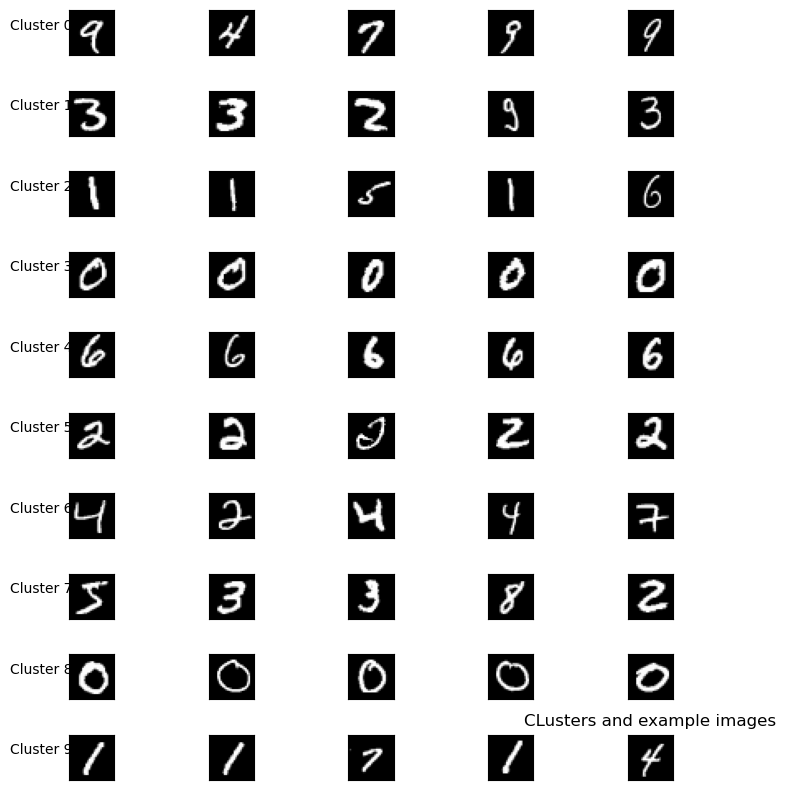

For cluster: 0 the most common label is: 7
For cluster: 1 the most common label is: 3
For cluster: 2 the most common label is: 1
For cluster: 3 the most common label is: 0
For cluster: 4 the most common label is: 6
For cluster: 5 the most common label is: 2
For cluster: 6 the most common label is: 4
For cluster: 7 the most common label is: 8
For cluster: 8 the most common label is: 0
For cluster: 9 the most common label is: 1


In [97]:

# init dict with clustering metrics
metrics_dict = {}

# KMEANS
n_clusters = len(set(y_train))
hyper_params = {'n_clusters': n_clusters}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, hyper_params, x_test, y_test)  
metrics_dict["kmeans"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))



### K Means ++

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


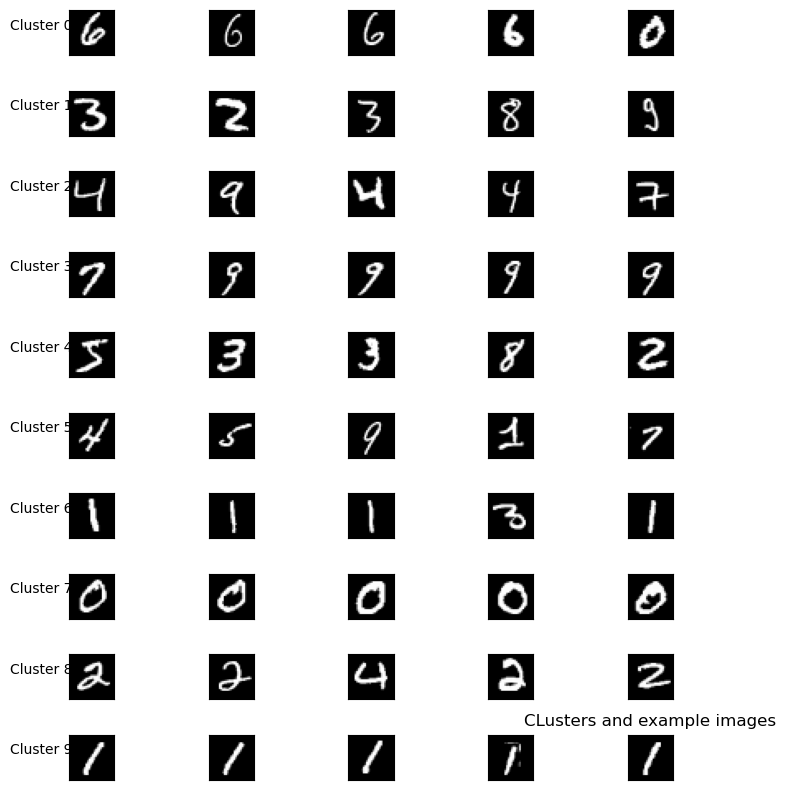

For cluster: 0 the most common label is: 6
For cluster: 1 the most common label is: 3
For cluster: 2 the most common label is: 4
For cluster: 3 the most common label is: 7
For cluster: 4 the most common label is: 3
For cluster: 5 the most common label is: 5
For cluster: 6 the most common label is: 1
For cluster: 7 the most common label is: 0
For cluster: 8 the most common label is: 2
For cluster: 9 the most common label is: 1


In [98]:
k_mean_plus_hyper_params = {'n_clusters': n_clusters, 'init': 'k-means++'}

silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, KMeans, k_mean_plus_hyper_params, x_test, y_test)  

metrics_dict["kmeans++"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


In [99]:
class AgglomerativeClusteringPredict(AgglomerativeClustering):
    def predict(self, x_test, x_train):
        # Get the cluster assignments of the training data
        labels = self.labels_
        # Get the unique cluster labels
        unique_labels = np.unique(labels)
        # Get the centroids of the clusters
        centroids = np.array([np.mean(x_train[labels == k], axis=0) for k in unique_labels])
        # Calculate the distance between each new data point and the centroids
        dist = np.array([np.linalg.norm(x_test - c, axis=1) for c in centroids])
        # Assign each new data point to the closest centroid's cluster
        return unique_labels[np.argmin(dist, axis=0)]


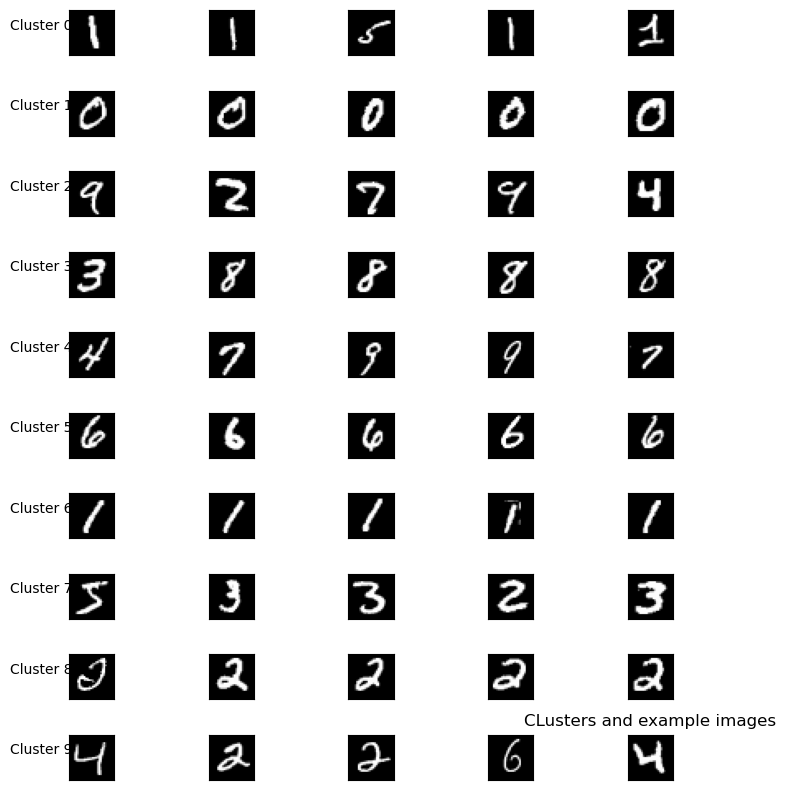

For cluster: 0 the most common label is: 1
For cluster: 1 the most common label is: 0
For cluster: 2 the most common label is: 9
For cluster: 3 the most common label is: 8
For cluster: 4 the most common label is: 4
For cluster: 5 the most common label is: 6
For cluster: 6 the most common label is: 1
For cluster: 7 the most common label is: 3
For cluster: 8 the most common label is: 2
For cluster: 9 the most common label is: 2


In [100]:
agg_hyper_params = {'n_clusters': 10}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, AgglomerativeClusteringPredict, agg_hyper_params, x_test, y_test)  

metrics_dict["agglomerative"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


#### GMM

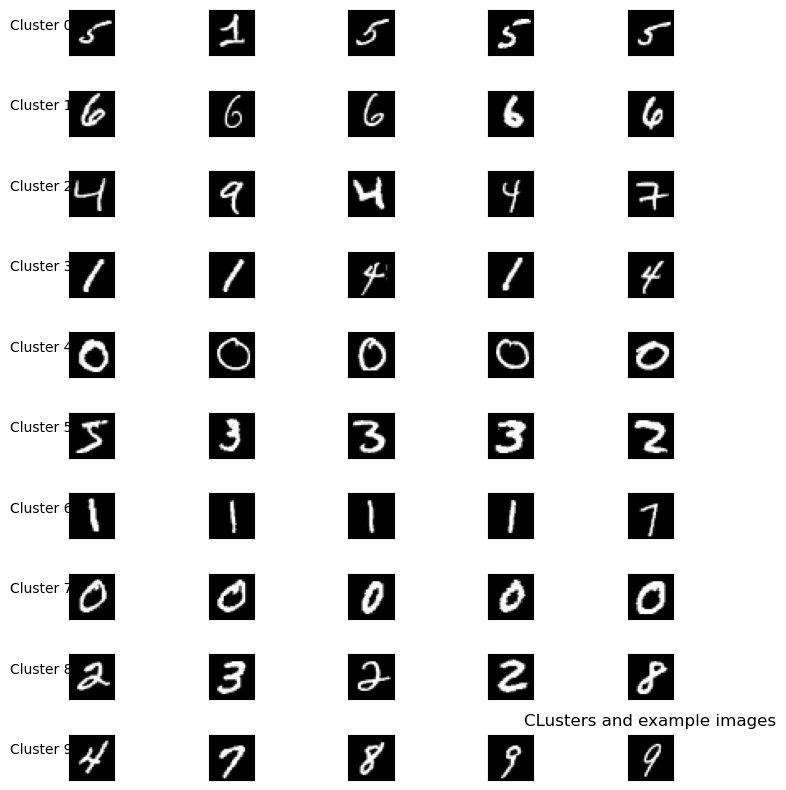

For cluster: 0 the most common label is: 5
For cluster: 1 the most common label is: 6
For cluster: 2 the most common label is: 4
For cluster: 3 the most common label is: 1
For cluster: 4 the most common label is: 0
For cluster: 5 the most common label is: 3
For cluster: 6 the most common label is: 1
For cluster: 7 the most common label is: 0
For cluster: 8 the most common label is: 2
For cluster: 9 the most common label is: 7


In [101]:
gmm_hyper_params = {'n_components': 10}
silhouette_avg, completeness_avg, homogeneity_avg, acc, f1 = run_pipeline(np.array(x_train), y_train, GaussianMixture, gmm_hyper_params, x_test, y_test)  

metrics_dict["gmm"] = dict(zip(["silhouette_avg", "completeness_avg", "homogeneity_avg", "acc", "f1"], [silhouette_avg, completeness_avg, homogeneity_avg, acc, f1]))


In [102]:
pd.DataFrame()

GaussianMixture()